### Interest Rate Regression Model using RandomForestRegressor+RandomCV

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.float_format = '{:.2f}'.format

In [44]:
data = pd.read_csv("lending-club-subset.csv")

In [45]:
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,109889419.00,nan,20000.00,20000.00,20000.00,36 months,9.44%,640.10,B,B1,IT Support,10+ years,MORTGAGE,99500.00,Source Verified,2017-05-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,296xx,SC,17.19,0.00,Feb-2005,690.00,694.00,0.00,nan,nan,15.00,0.00,12835.00,41%,28.00,w,0.00,0.00,21657.67,21657.67,20000.00,1657.67,0.00,0.00,0.00,Jun-2018,1002.69,nan,Jul-2018,744.00,740.00,0.00,nan,1.00,Individual,nan,nan,NaN,0.00,1185.00,159516.00,2.00,3.00,0.00,2.00,16.00,59354.00,70.00,2.00,2.00,4810.00,57.00,31300.00,2.00,0.00,1.00,4.00,10634.00,15465.00,45.40,0.00,0.00,147.00,115.00,3.00,3.00,4.00,3.00,nan,7.00,nan,0.00,4.00,4.00,7.00,9.00,8.00,11.00,16.00,4.00,15.00,0.00,0.00,0.00,2.00,100.00,28.60,0.00,0.00,206029.00,72189.00,28300.00,84078.00,nan,nan,nan,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,N,NaN,NaN,NaN,nan,nan,NaN,NaN,NaN,nan,nan,NaN,nan,nan,nan,N,NaN,NaN,NaN,nan,nan,nan
1,68579794.00,nan,21600.00,21600.00,21600.00,36 months,9.80%,694.95,B,B3,Engineer Tech,10+ years,MORTGAGE,79000.00,Verified,2016-01-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,219xx,MD,18.94,1.00,Jun-1995,680.00,684.00,0.00,12.00,nan,13.00,0.00,17498.00,88.4%,16.00,w,0.00,0.00,24983.21,24983.21,21600.00,3383.21,0.00,0.00,0.00,Nov-2018,8.94,nan,May-2019,709.00,705.00,0.00,nan,1.00,Individual,nan,nan,NaN,0.00,0.00,291267.00,0.00,2.00,2.00,2.00,7.00,33987.00,88.00,0.00,0.00,4746.00,88.00,19800.00,0.00,0.00,0.00,2.00,22405.00,897.00,91.10,0.00,0.00,101.00,247.00,27.00,7.00,4.00,27.00,12.00

In [46]:
data['term'].value_counts()

 36 months    102996
 60 months     25338
Name: term, dtype: int64

In [47]:
data.shape

(128334, 150)

In [48]:
data = data[[
    'loan_amnt'
    , 'funded_amnt'
    , 'funded_amnt_inv'
    , 'term'
    , 'int_rate'
    , 'installment'
    , 'grade'
    , 'sub_grade'
    , 'emp_title'
    , 'emp_length'
    , 'home_ownership'
    , 'annual_inc'
    , 'verification_status'
    , 'issue_d'
    , 'loan_status'
    , 'purpose'
    , 'addr_state'
    , 'dti'
    , 'delinq_2yrs'
    , 'fico_range_low'
    , 'fico_range_high'
    , 'inq_last_6mths'
    , 'mths_since_last_delinq'
    , 'mths_since_last_record'
    , 'open_acc'
    , 'pub_rec'
    , 'revol_bal'
    , 'revol_util'
    , 'total_acc'
    , 'initial_list_status'
    , 'acc_open_past_24mths'
    , 'mort_acc'
    , 'pub_rec_bankruptcies'
    , 'tax_liens'
    , 'earliest_cr_line'
]]

In [49]:
# remove % sign and set to float
data['int_rate'] = data['int_rate'].str.replace('%', '')
data['int_rate'] = data['int_rate'].astype(float)

data['revol_util'] = data['revol_util'].str.replace('%', '')
data['revol_util'] = data['revol_util'].astype(float)

data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,acc_open_past_24mths,mort_acc,pub_rec_bankruptcies,tax_liens,earliest_cr_line
0,20000.00,20000.00,20000.00,36 months,9.44,640.10,B,B1,IT Support,10+ years,MORTGAGE,99500.00,Source Verified,2017-05-01,Fully Paid,debt_consolidation,SC,17.19,0.00,690.00,694.00,0.00,nan,nan,15.00,0.00,12835.00,41.00,28.00,w,4.00,4.00,0.00,0.00,Feb-2005
1,21600.00,21600.00,21600.00,36 months,9.80,694.95,B,B3,Engineer Tech,10+ years,MORTGAGE,79000.00,Verified,2016-01-01,Fully Paid,debt_consolidation,MD,18.94,1.00,680.00,684.00,0.00,12.00,nan,13.00,0.00,17498.00,88.40,16.00,w,2.00,4.00,0.00,0.00,Jun-1995
2,25000.00,25000.00,24950.00,36 months,17.57,898.43,D,D2,Retail manager,7 years,MORTGAGE,90100.00,Source Verified,2013-12-01,Fully Paid,home_improvement,MA,19.58,1.00,695.00,699.00,0.00,0.00,nan,15.00,0.00,12440.00,49.00,36.00,f,3.00,3.00,0.00,0.00,Mar-1994
3,5000.00,5000.00,5000.00,36 months,6.89,154.14,A,A3,Business Analyst,3 years,MORTGAGE,110139.00,Verified,2015-08-01,Fully Paid,credit_card,MO,33.01,0.00,715.00,719.00,0.00,nan,nan,19.00,0.00,29415.00,84.80,52.00,w,4.00,2.00,0.00,0.00,Oct-1998
4,11850.00,11850.00,11850.00,36 months,14.16,405.93,C,C2,Account Supervisor,6 years,RENT,50500.00,Source Verified,2014-02-01,Fully Paid,credit_card,TN,20.82,0.00,670.00,674.00,2.00,69.00,nan,9.00,0.00,6774.00,61.60,15.00,f,6.00,0.00,0.00,0.00,Apr-2003


In [50]:
data.isnull().sum()

loan_amnt                      0
funded_amnt                    0
funded_amnt_inv                0
term                           0
int_rate                       0
installment                    0
grade                          0
sub_grade                      0
emp_title                   8396
emp_length                  7663
home_ownership                 0
annual_inc                     0
verification_status            0
issue_d                        0
loan_status                    0
purpose                        0
addr_state                     0
dti                           51
delinq_2yrs                    0
fico_range_low                 0
fico_range_high                0
inq_last_6mths                 0
mths_since_last_delinq     65175
mths_since_last_record    106694
open_acc                       0
pub_rec                        0
revol_bal                      0
revol_util                    83
total_acc                      0
initial_list_status            0
acc_open_p

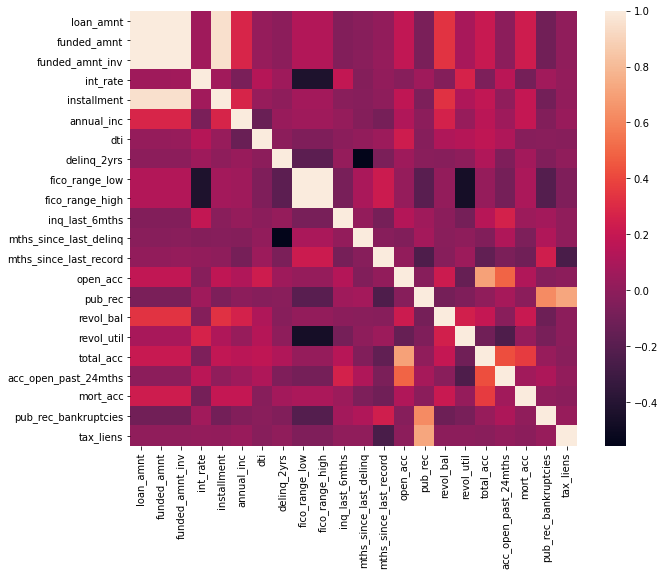

In [51]:
corr = data.corr()
plt.figure(figsize = (10, 8))
sns.heatmap(corr)
plt.show()

In [52]:
corr_int_rate = corr[['int_rate']]
corr_int_rate

,int_rate
loan_amnt,0.06
funded_amnt,0.06
funded_amnt_inv,0.06
int_rate,1.00
installment,0.07
annual_inc,-0.08
dti,0.14
delinq_2yrs,0.05
fico_range_low,-0.43
fico_range_high,-0.43


In [53]:
top_10_pos = corr_int_rate[corr_int_rate['int_rate'] > 0].sort_values(by=['int_rate'],ascending=False)
top_10_pos

,int_rate
int_rate,1.00
revol_util,0.27
inq_last_6mths,0.19
acc_open_past_24mths,0.16
dti,0.14
pub_rec_bankruptcies,0.07
installment,0.07
funded_amnt_inv,0.06
funded_amnt,0.06
loan_amnt,0.06


In [54]:
top_10_neg = corr_int_rate[corr_int_rate['int_rate']< 0].sort_values(by=['int_rate'],ascending=False)
top_10_neg

,int_rate
open_acc,-0.02
mths_since_last_delinq,-0.03
revol_bal,-0.04
total_acc,-0.06
annual_inc,-0.08
mort_acc,-0.09
fico_range_high,-0.43
fico_range_low,-0.43


### Try Features Importance to compare

In [17]:
# Split Data 
from sklearn.model_selection import train_test_split
train, test  = train_test_split(data, test_size=0.90, random_state=42)

train.shape, test.shape

((12833, 35), (115501, 35))

In [18]:
target = 'int_rate'
features = train.columns.drop(['int_rate'
                               ,'revol_bal'
                               ,'loan_status'
                               ,'funded_amnt'
                               ,'grade'
                               ,'sub_grade'
                               ,'issue_d'
                               ,'installment'
                               , 'fico_range_high' 
                               , 'funded_amnt_inv'])

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.metrics import mean_absolute_error

In [20]:
# encoder = ce.OneHotEncoder()
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

impute = SimpleImputer()
X_train_impute = impute.fit_transform(X_train_encoded)
X_test_impute = impute.transform(X_test_encoded)

model = RandomForestRegressor()

model.fit(X_train_impute, y_train)
y_pred = model.predict(X_test_impute)

mae = mean_absolute_error(y_test, y_pred)

In [21]:
print(f'Test MAE: %{mae:,.02f}')

Test MAE: %2.24


In [22]:
model.score(X_test_impute, y_test)

0.426690886866799

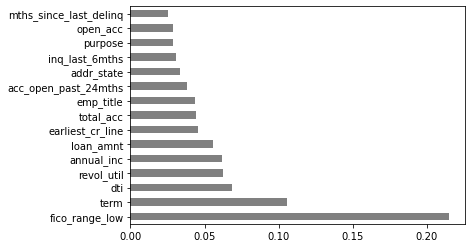

In [23]:
feature_names = X_train.columns
importances = pd.Series(model.feature_importances_, index=feature_names)
plt.figure()
importances.sort_values(ascending=False)[:15].plot.barh(color='grey');

In [24]:
from sklearn.inspection import permutation_importance
r = permutation_importance(model, X_train_impute, y_train, n_repeats=5,random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{X_train.columns[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

fico_range_low0.648 +/- 0.008
term    0.369 +/- 0.006
inq_last_6mths0.174 +/- 0.002
dti     0.155 +/- 0.001
annual_inc0.154 +/- 0.002
initial_list_status0.153 +/- 0.002
revol_util0.142 +/- 0.002
acc_open_past_24mths0.110 +/- 0.001
loan_amnt0.103 +/- 0.001
total_acc0.081 +/- 0.001
purpose 0.081 +/- 0.001
emp_title0.054 +/- 0.000
earliest_cr_line0.051 +/- 0.000
verification_status0.047 +/- 0.001
mort_acc0.039 +/- 0.001
addr_state0.037 +/- 0.000
open_acc0.035 +/- 0.000
mths_since_last_delinq0.027 +/- 0.000
emp_length0.026 +/- 0.000
home_ownership0.011 +/- 0.000
mths_since_last_record0.010 +/- 0.000
pub_rec 0.004 +/- 0.000
delinq_2yrs0.004 +/- 0.000
pub_rec_bankruptcies0.002 +/- 0.000
tax_liens0.001 +/- 0.000


### TRAIN RFR with new Features

In [55]:
top_feats = ["fico_range_low"
             , 'term'
             , 'dti'
             , 'revol_util'
             , 'annual_inc'
             , 'loan_amnt'
             , 'purpose'
             , 'int_rate']

new_data = data[top_feats]
new_data.head()

,fico_range_low,term,dti,revol_util,annual_inc,loan_amnt,purpose,int_rate
0,690.00,36 months,17.19,41.00,99500.00,20000.00,debt_consolidation,9.44
1,680.00,36 months,18.94,88.40,79000.00,21600.00,debt_consolidation,9.80
2,695.00,36 months,19.58,49.00,90100.00,25000.00,home_improvement,17.57
3,715.00,36 months,33.01,84.80,110139.00,5000.00,credit_card,6.89
4,670.00,36 months,20.82,61.60,50500.00,11850.00,credit_card,14.16


In [56]:
new_data.shape

(128334, 8)

In [73]:
# Split Data 
from sklearn.model_selection import train_test_split
train, test  = train_test_split(new_data, test_size=0.80, random_state=42)

train.shape, test.shape

((25666, 8), (102668, 8))

In [74]:
target = 'int_rate'
features = train.columns.drop(['int_rate'])

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [75]:
from sklearn.pipeline import make_pipeline, Pipeline
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestRegressor(random_state=42),
)

param_distributions = {
    'randomforestregressor__n_estimators': randint(50,500),
    'randomforestregressor__max_depth': [5,10,15,20,None], 
    'randomforestregressor__max_features': uniform(0,1),
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions = param_distributions,
    n_iter=10,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
    
)
search.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   11.5s
/Users/smash/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   30.6s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   34.1s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   35.2s finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('simpleimputer', SimpleImputer()),
                                             ('randomforestregressor',
                                              RandomForestRegressor(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'randomforestregressor__max_depth': [5,
                                                                             10,
                                                                             15,
                                                                             20,
                                                                             None],
                                        'randomforestregressor__max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe84e60ff10>,
                 

In [76]:
search.best_estimator_

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['term', 'purpose'],
                                mapping=[{'col': 'term',
                                          'data_type': dtype('O'),
                                          'mapping':  36 months    1
 60 months    2
NaN          -2
dtype: int64},
                                         {'col': 'purpose',
                                          'data_type': dtype('O'),
                                          'mapping': credit_card            1
home_improvement       2
debt_consolidation     3
medical                4
major_purchase         5
other                  6
small_business         7
car                    8
vacation               9
moving                10
wedding               11
renewable_energy      12
educational           13
house                 14
NaN                   -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('randomforestregressor',


In [77]:
pipeline = search.best_estimator_

In [78]:
print('neg_root_mean_squared_error', search.best_score_)

neg_root_mean_squared_error -2.909627464039807


In [79]:
y_pred = search.predict(X_test)

In [80]:
mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: %{mae:,.02f}')

Test MAE: %2.33


In [81]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.3808260379986098

In [82]:
def predict(fico_range_low, term, dti, revol_util, annual_inc,loan_amnt,purpose):
    df = pd.DataFrame(
        columns=["fico_range_low"
             , 'term'
             , 'dti'
             , 'revol_util'
             , 'annual_inc'
             , 'loan_amnt'
             , 'purpose'], 
        data=[[fico_range_low, term, dti, revol_util, annual_inc,loan_amnt,purpose]]
    )
    y_pred = pipeline.predict(df)[0]
    return f'{y_pred:.2f}% Interest Rate'

In [83]:
predict(fico_range_low = 800, term = "36 months", dti = 20, revol_util = 40, annual_inc = 100000,loan_amnt = 40000,purpose = 'debt_consolidation')

'8.50% Interest Rate'

In [84]:
predict(fico_range_low = 600, term = "60 months", dti = 40, revol_util = 40, annual_inc = 10000,loan_amnt = 40000,purpose = 'debt_consolidation')

'14.93% Interest Rate'

In [86]:
from joblib import dump
dump(pipeline, 'pipeline.joblib')

['pipeline.joblib']